# 学習と評価
 - FaceNetの利用

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
from pathlib import Path

In [6]:
import tensorflow as tf

In [7]:
tf.__version__

'2.8.0'

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [9]:
from sklearn.model_selection import KFold

### GPU使用時のTFの再現性確保を担保する
cf. https://book-read-yoshi.hatenablog.com/entry/2021/03/21/TensorFlow_determinism

In [83]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import tensorflow as tf
os.environ['TF_DETERMINISTIC_OPS'] = 'true'
os.environ['TF_CUDNN_DETERMINISTIC'] = 'true'

import numpy as np
import random as rn

SEED = 1001
def reset_random_seeds():
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    rn.seed(SEED)

reset_random_seeds()    

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=32)
tf.compat.v1.set_random_seed(SEED)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

## データのロード

- 画像サイズは224×224

In [10]:
df = pd.read_csv("data1_union.csv")

In [11]:
df

,Id,Caring,Confident,Emotionally stable,Intelligent,Responsible,Sociable,Trustworthy
0,6269,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,272998,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,274783,1.0,1.0,0.0,0.0,1.0,1.0,1.0
3,430823,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,208848,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
80,185955,0.0,1.0,1.0,1.0,1.0,0.0,0.0
81,313100,0.0,1.0,0.0,0.0,0.0,0.0,1.0
82,369866,1.0,1.0,0.0,1.0,1.0,0.0,0.0
83,124821,0.0,1.0,1.0,1.0,0.0,0.0,1.0


## FaceNetで埋め込み

メモ：```\Lib\site-packages\facenet\src\facenet.py```の408行目をtensorflow v2仕様に書き換える必要がある

In [12]:
from face_embedding import FaceEmbedding

In [13]:
FACE_MEDEL_PATH = '../facenet//20180402-114759/20180402-114759.pb'
face_embedding = FaceEmbedding(FACE_MEDEL_PATH)

Model filename: ../facenet//20180402-114759/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.


In [14]:
X = []
for img_id in df["Id"]:
    path = f"images/cleaned_20220519/{img_id}.jpg"
    face_vec = face_embedding.face_embeddings(path)[0]
    X.append(face_vec)

In [15]:
X = np.array(X)

In [16]:
X.shape

(85, 512)

# 二値分類モデル

## モデル構築

In [17]:
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPool2D, Lambda, Conv2D, Reshape, Input, RandomFlip, RandomRotation

In [68]:
def get_binary_model():
    input_ts = Input(shape=(512,))
    dense1 = Dense(512, activation="relu")(input_ts)
    dense2 = Dense(1024, activation="relu")(dense1)
    drop1 = Dropout(0.4)(dense2)
    dense3 = Dense(1024, activation="relu")(drop1)
    drop2 = Dropout(0.4)(dense3)
    dense4 = Dense(512, activation="relu")(drop2)
    dense5 = Dense(256, activation="relu")(dense4)
    dense6 = Dense(128, activation="relu")(dense5)
    drop3 = Dropout(0.2)(dense6)
    final = Dense(2, activation="softmax")(drop3)
    
    model = Model(
        inputs=[input_ts],
        outputs=[final]
    )
    return model

In [24]:
model = get_binary_model()

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               5248

In [26]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [27]:
del model

In [28]:
kf = KFold(n_splits=3, shuffle=True, random_state=1001)

In [29]:
from sklearn.metrics import f1_score

cf. https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric/notebook

In [40]:
from tensorflow.keras import backend as K

In [45]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

## すべてのラベルでやってみる

In [46]:
labels = ["Caring","Confident","Emotionally stable","Intelligent","Responsible","Sociable","Trustworthy"]

In [47]:
kf = KFold(n_splits=3, shuffle=True, random_state=1001)

In [74]:
import gc

In [84]:
f1_dict = dict()

for label in labels:
    y_raw = df[label]
    y = tf.keras.utils.to_categorical(y_raw)
    
    f1_dict[label] = []
    print(label)
    
    for train_index, test_index in kf.split(X):     
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        neg = y_train.sum(axis=0)[0]
        pos = y_train.sum(axis=0)[1]
        total = pos + neg
        print(f"origin pos:{pos} neg:{neg}")

        # クラスの重み
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        model = get_binary_model()
        
        # 初期重みの最適化
        initial_bias = np.log([neg/pos])
        model.layers[-1].bias_initializer=initial_bias
        
        model.compile(loss=f1_loss, optimizer="adam", metrics=METRICS)
        model.fit(X_train, y_train, batch_size=8, epochs=6, class_weight=class_weight)
        y_pred_tf = model.predict(X_test, batch_size=1)
        y_pred = np.argmax(y_pred_tf, axis=1)
        y_test_sk = np.argmax(y_test, axis=1)
        print("Predict:", y_pred)
        print("True:", y_test_sk)
        f1 = f1_score(y_test_sk, y_pred, average="binary")
        print("F1 score:", f1)
        f1_dict[label].append(f1)
        del model
        gc.collect()
    

Caring
origin pos:21.0 neg:35.0
Epoch 1/6
7/7 [==============================] - 1s 21ms/step - loss: 0.5182 - tp: 85.0000 - fp: 28.0000 - tn: 85.0000 - fn: 28.0000 - accuracy: 0.7522 - precision: 0.7522 - recall: 0.7522 - auc: 0.8541
Epoch 2/6
7/7 [==============================] - 0s 20ms/step - loss: 0.5093 - tp: 35.0000 - fp: 21.0000 - tn: 35.0000 - fn: 21.0000 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6993
Epoch 3/6
7/7 [==============================] - 0s 7ms/step - loss: 0.4183 - tp: 38.0000 - fp: 18.0000 - tn: 38.0000 - fn: 18.0000 - accuracy: 0.6786 - precision: 0.6786 - recall: 0.6786 - auc: 0.7958
Epoch 4/6
7/7 [==============================] - 0s 7ms/step - loss: 0.2754 - tp: 49.0000 - fp: 7.0000 - tn: 49.0000 - fn: 7.0000 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.9190
Epoch 5/6
7/7 [==============================] - 0s 7ms/step - loss: 0.0715 - tp: 54.0000 - fp: 2.0000 - tn: 54.0000 - fn: 2.0000 - accuracy: 0.9643 - precision

8/8 [==============================] - 0s 12ms/step - loss: 0.0583 - tp: 57.0000 - fp: 0.0000e+00 - tn: 57.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Predict: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0]
True: [1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1]
F1 score: 0.7826086956521738
Emotionally stable
origin pos:16.0 neg:40.0
Epoch 1/6
7/7 [==============================] - 1s 7ms/step - loss: 0.5267 - tp: 94.0000 - fp: 19.0000 - tn: 94.0000 - fn: 19.0000 - accuracy: 0.8319 - precision: 0.8319 - recall: 0.8319 - auc: 0.9281
Epoch 2/6
7/7 [==============================] - 0s 7ms/step - loss: 0.4825 - tp: 40.0000 - fp: 16.0000 - tn: 40.0000 - fn: 16.0000 - accuracy: 0.7143 - precision: 0.7143 - recall: 0.7143 - auc: 0.7883
Epoch 3/6
7/7 [==============================] - 0s 7ms/step - loss: 0.4119 - tp: 40.0000 - fp: 16.0000 - tn: 40.0000 - fn: 16.0000 - accuracy: 0.7143 - precision: 0.7143 - recall: 0.7143 - auc

8/8 [==============================] - 0s 13ms/step - loss: 0.4749 - tp: 33.0000 - fp: 24.0000 - tn: 33.0000 - fn: 24.0000 - accuracy: 0.5789 - precision: 0.5789 - recall: 0.5789 - auc: 0.6713
Epoch 5/6
8/8 [==============================] - 0s 8ms/step - loss: 0.3318 - tp: 44.0000 - fp: 13.0000 - tn: 44.0000 - fn: 13.0000 - accuracy: 0.7719 - precision: 0.7719 - recall: 0.7719 - auc: 0.8456
Epoch 6/6
8/8 [==============================] - 0s 8ms/step - loss: 0.1367 - tp: 53.0000 - fp: 4.0000 - tn: 53.0000 - fn: 4.0000 - accuracy: 0.9298 - precision: 0.9298 - recall: 0.9298 - auc: 0.9471
Predict: [0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1]
True: [0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1]
F1 score: 0.5625000000000001
Responsible
origin pos:25.0 neg:31.0
Epoch 1/6
7/7 [==============================] - 1s 7ms/step - loss: 0.5179 - tp: 80.0000 - fp: 33.0000 - tn: 80.0000 - fn: 33.0000 - accuracy: 0.7080 - precision: 0.7080 - recall: 0.7080 - auc: 0.8232
Epoch 

8/8 [==============================] - 0s 8ms/step - loss: 0.4570 - tp: 37.0000 - fp: 20.0000 - tn: 37.0000 - fn: 20.0000 - accuracy: 0.6491 - precision: 0.6491 - recall: 0.6491 - auc: 0.7956
Epoch 4/6
8/8 [==============================] - 0s 8ms/step - loss: 0.3235 - tp: 44.0000 - fp: 13.0000 - tn: 44.0000 - fn: 13.0000 - accuracy: 0.7719 - precision: 0.7719 - recall: 0.7719 - auc: 0.9135
Epoch 5/6
8/8 [==============================] - 0s 8ms/step - loss: 0.1474 - tp: 54.0000 - fp: 3.0000 - tn: 54.0000 - fn: 3.0000 - accuracy: 0.9474 - precision: 0.9474 - recall: 0.9474 - auc: 0.9809 
Epoch 6/6
8/8 [==============================] - 0s 9ms/step - loss: 0.0573 - tp: 57.0000 - fp: 0.0000e+00 - tn: 57.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Predict: [0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0]
True: [0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0]
F1 score: 0.25
Trustworthy
origin pos:10.0 neg:46.0
Epoch 1/6
7/7 

In [85]:
f1_list = []
for label in labels:
    f1_list.append(np.mean(f1_dict[label]))
macro_f1_val = np.mean(f1_list) 

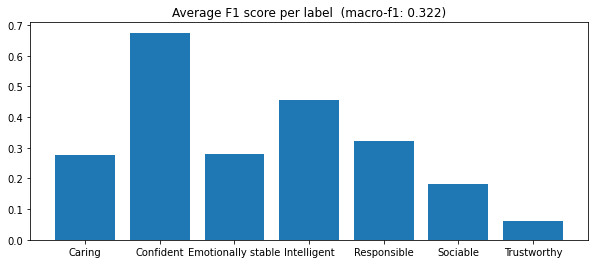

In [86]:
plt.figure(figsize=(10,4))
plt.bar(f1_dict.keys(), f1_list)
plt.title(f"Average F1 score per label  (macro-f1: {macro_f1_val:.3f})")
plt.show() ;

### いろいろやってみてわかること
 - Predictを見るとわかるが，まったく学習できていない
 - 役に立たない　やはりデータが少なすぎるか
 - f1をlossに用いるほうが全然良い
 - macro-f1はf1の平均

In [ ]:
from numba import cuda

# 下記の場合は/gpu:0に関してCUDA処理をcloseしています。
cuda.select_device(0)
cuda.close()

# マルチラベル問題

In [ ]:
del model

cf．https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72

In [88]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [180]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [181]:
def get_multi_model():
    input_ts = Input(shape=(512,))
    dense1 = Dense(512, activation="relu")(input_ts)
    dense2 = Dense(1024, activation="relu")(dense1)
    drop1 = Dropout(0.4)(dense2)
    dense3 = Dense(1024, activation="relu")(drop1)
    drop2 = Dropout(0.4)(dense3)
    dense4 = Dense(512, activation="relu")(drop2)
    dense5 = Dense(256, activation="relu")(dense4)
    dense6 = Dense(128, activation="relu")(dense5)
    drop3 = Dropout(0.2)(dense6)
    final = Dense(len(labels), activation="sigmoid")(drop3)
    
    model = Model(
        inputs=[input_ts],
        outputs=[final]
    )
    return model

In [182]:
model = get_multi_model()

In [183]:
model.summary()

Model: "model_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_174 (InputLayer)      [(None, 512)]             0         
                                                                 
 dense_1211 (Dense)          (None, 512)               262656    
                                                                 
 dense_1212 (Dense)          (None, 1024)              525312    
                                                                 
 dropout_519 (Dropout)       (None, 1024)              0         
                                                                 
 dense_1213 (Dense)          (None, 1024)              1049600   
                                                                 
 dropout_520 (Dropout)       (None, 1024)              0         
                                                                 
 dense_1214 (Dense)          (None, 512)               52

In [184]:
df["Confident"].sum()

65.0

In [185]:
y_raw = np.array(df.T[1:].T)

In [186]:
y_raw[:10]

array([[1., 0., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 0., 1., 1., 1., 0.],
       [1., 1., 1., 0., 1., 1., 1.]])

In [187]:
y = tf.keras.utils.to_categorical(y_raw)

In [188]:
y[0:2]

array([[[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]], dtype=float32)

In [189]:
y.sum(axis=0).T[1] # 各ラベルの数

array([26., 65., 29., 50., 41., 30., 19.], dtype=float32)

In [190]:
y_preds = []
for train_index, test_index in kf.split(X):     
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    """
    label_num = y_train.sum(axis=0).T[1] # 各ラベルの数
    total = label_num.sum()
    print(f"origin {label_num}")

    # クラスの重み
    class_weight = dict()
    for i,n in enumerate(label_num):
        w = (1 / n) * (total / len(labels))
        class_weight[i] = w
    """

    model = get_multi_model()

    model.compile(loss=macro_soft_f1, optimizer="adam", metrics=[macro_f1])
    model.fit(X_train, y_train, batch_size=8, epochs=5)
    model.evalate(X_test,y_test)
    y_pred = model.predict(X_test, batch_size=1)
    y_preds.append(y_pred)
    del model
    gc.collect()

Epoch 1/5


ValueError: in user code:

    File "C:\Users\Owner\python_venvs\tensorflow\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Owner\AppData\Local\Temp\ipykernel_22172\2301777809.py", line 15, in macro_soft_f1  *
        tp = tf.compat.v1.reduce_sum(y_hat * y, axis=0)

    ValueError: Dimensions must be equal, but are 8 and 7 for '{{node mul}} = Mul[T=DT_FLOAT](y_hat, y)' with input shapes: [8,7], [8,7,2].
